# Overview of Day 4
* Preliminaries
* The philosophy of machine learning
* Machine learning in Python: why scikit-learn?
* Feature extraction
* Feature selection
* Estimation
* Evaluation
* Automation


In [1]:
# We'll load scikit-learn modules as we go,
# so we can see what we're using.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Read in our preprocessed data set from Day 3.
# You may need to modify the path to the file
# depending on where you put it on your computer.
data = pd.read_csv('../data/preprocessed_data.csv')

# Since we'll be predicting outcomes, let's restrict
# to only common ones. It's hard to predict something
# we don't have very many training examples of.
data = data.groupby('outcome').filter(lambda x: len(x) >= 500)

# Let's also do some recoding to make life easier
data = data.dropna(subset=['age'])
categoricals = ['sex', 'sterilized']
data[categoricals] = data[categoricals].fillna('Unknown')

# Important, otherwise we have problems later
# when we try to concatenate based on index
data = data.reset_index()

/Users/tal/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# The philosophical foundations of machine learning
* There aren't really (m)any
* Machine learning is an almost ruthlessly pragmatic field
* Good prediction is (usually) the main focus of analysis
    * Understanding only matters to the extent it helps prediction
* This makes iterative model-fitting much more rapid
    * Don't need to understand _why_ something works, just need to feel confident that it _does_ work
* Places a premium on objective tests of predictive accuracy

# Machine learning in Python: why scikit-learn?
* There are hundreds of ML packages in Python
    * Theano, Tensorflow, orange, Pattern, PyMVPA, etc...
* But scikit-learn is dominant
    * Elegant, powerful interface
    * World-class documentation
    * Excellent performance
* The exception is deep learning--not supported in scikit-learn

# The typical predictive modeling pipeline
* Feature extraction/engineering
* Feature selection
* Model/parameter selection
* Estimation
* Evaluation
* Rinse and repeat ad nauseam

# Feature extraction
* The process of transforming data into more data
* We already did lot of this on Day 2
* But let's revisit the issue in this new predictive light

## Getting _all_ the features
* Well, probably not all... but a _lot_
* How much information can we get out of the original dataset?
* From an interpretation-oriented standpoint, maybe not much more
* From a machine learning standpoint, we've just scratched the surface
* Some things we could add: names, colors, any number of interactions...
    * The cost of trying out silly things is much lower
    * Multicollinearity is not (much of) a concern

## The bag-of-words model
* If you have a lot of data, it's not always worth thinking deeply about your features
* E.g., how should we model fur color?
    * "Black/Tricolor", "Calico Point", "Brown Brindle/Blue Cream"
* Simple approach: treat color descriptions like a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)
* Extract all word tokens (possibly even N-grams)

In [2]:
# First 20 unique colors in the dataset
data['color'].unique()[:20]

array(['Yellow/White', 'Tricolor', 'Brown/White', 'Black/White',
       'Black/Gray', 'White/Black', 'Brown Tabby/White', 'Black/Tan',
       'Tan/Black', 'Black', 'Gold/Gold', 'Sable/White', 'Blue Merle/Tan',
       'Blue Merle', 'Brown/Black', 'Black/Tricolor', 'Black/Black', 'Tan',
       'Cream', 'Red'], dtype=object)

### Applying the bag-of-words model

In [3]:
# The CountVectorizer is an estimator that takes a series
# of documents (or strings) as input, and returns a count
# of every word token found in every document. There's also
# a TfidfVectorizer in cases where we want normalized frequency.
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer with default parameters.
# Some common arguments we might want to experiment with
# include min_df and max_df (which exclude words that are
# too frequent or infrequent), stop_words (which allows
# us to pass in a list of words to ignore), and ngram_range,
# which enables us to extract multi-word features.
vec = CountVectorizer()

# Extract all possible word features from the color list.
# Note that this returns a sparse matrix rather than a
# numpy array or a pandas DataFrame. A sparse matrix is
# a way of representing potentially very large 2-d arrays
# very efficiently, because we don't need to allocate
# memory for every cell in the array, only those that
# have a non-zero value.
fur_features = vec.fit_transform(data['color'])
print("fur_features is an object of type:", type(fur_features))

# After fitting, the names of the features (i.e., the
# columns of the sparse matrix returned by fit_transform())
# are stored in the estimator itself.
feature_names = vec.get_feature_names()

# Store in a pandas DF for easier manipulation later.
# Note that we convert the sparse array back to a dense
# one before loading into pandas. If our dataset were
# much bigger, we'd probably want to avoid this step
# and just keep working with the sparse matrix.
fur_features = pd.DataFrame(fur_features.todense(), columns=feature_names)

fur_features is an object of type: <class 'scipy.sparse.csr.csr_matrix'>


In [4]:
# Let's take a look...
# fur_features.head(10)
fur_features.sum(axis=0).sort_values(ascending=False)

white        17625
black        12305
brown        10606
tabby         7294
tan           4393
blue          3378
orange        2018
brindle       1484
red           1475
tricolor      1321
gray           996
cream          911
tortie         873
point          848
calico         798
chocolate      746
torbie         562
sable          485
merle          458
yellow         443
buff           439
fawn           299
lynx           281
seal           235
silver         180
tick           156
smoke          120
flame          119
gold           114
lilac           58
apricot         47
liver           45
green           33
pink            27
tiger           23
agouti           6
ruddy            1
dtype: int64

### Adding interaction terms
* We could dummy-code all our categorical variables and then take pairwise products
* But if we don't need interpretabilty, there's a simpler hack
    * Concatenate all variables for which we want interactions
    * Dummy-code the result
* Let's cross sex, sterilization, and breed (that's a lot of features!)

In [7]:
# Simply concatenate the columns we want--making sure to convert any numeric
# columns to string, otherwise the concatenation will fail.
data['ssb'] = data['sex'].astype(str) + '_' + data['sterilized'].astype(str) + '_' + data['breed']

# How many unique levels?
num_levels = data['ssb'].nunique()
print("Total number of unique values: {}".format(num_levels))

# Now we can dummy-code the result
# pd.get_dummies(data['ssb']).head(10)

Total number of unique values: 3150


### What else?
* Very easy to quickly build up thousands of derivative features in this way
* Doesn't mean we shouldn't think deeply about good features
    * Often, biggest jumps in performance are achieved by adding entirely new features
* Point is try to eke out every bit of signal from what we have

# Feature selection/reduction
* Not all features are created equal
* Just because we created 10,000 features doesn't mean we need to include them all
* Two general approaches:
    * Dimensionality reduction (extract latent signal from observed features)
    * Feature selection (filter out features based on some criterion)
* Supported by the feature_selection, clustering, and decomposition modules in sklearn

### Decomposition
* Techniques for decomposing/factoring matrices
    * [sklearn.decomposition](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition)
    * PCA, ICA, dictionary learning, many others
* Reduce dimensionality by extracting signal common to multiple features
* Can we reduce our 3,000+ strong set of features to a smaller number?

In [8]:
# First we need to recode our string column as a set of dummies
interaction_dummies = pd.get_dummies(data['ssb'])

# Let's concatenate this with the color features
# axis=1 indicates that we want to concatenate along
# the column axis (axis=0 would append each dataframe
# below the last.
lotsa_features = pd.concat([fur_features, interaction_dummies], axis=1)

# Like most other things in sklearn, decomposition classes
# implement the estimator interface. So they have fit() and
# predict() methods. Transformers also have a transform()
# method. First, we initialize the RandomizedPCA transformer.
# RandomizedPCA is a speedier approximation of the standard
# principal component analysis (PCA) factorization. We need to
# specify the number of components we want at initialization.
# We'll take the first 100.
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(100)

# Now we can fit and transform in one step
pca_features = pca.fit_transform(lotsa_features)

In [9]:
# How much of the variance do these components explain?
exp_variance = pca.explained_variance_ratio_.sum()
msg = "All components collectively explain {:.0%} of the variance."
print(msg.format(exp_variance))

All components collectively explain 87% of the variance.


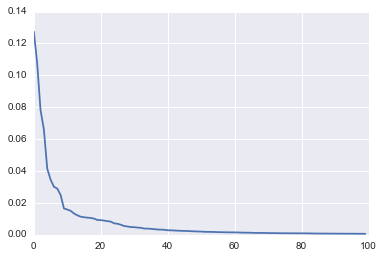

In [10]:
# Let's take a look at the scree plot
plt.plot(pca.explained_variance_ratio_)

In [11]:
# We can look at the loadings if we want to try to understand what's going on
components = pca.components_
loadings = pd.DataFrame(components, columns=lotsa_features.columns)
loadings.iloc[0].sort_values(ascending=False)

# As an exercise, you can come up with a better way to visualize what's
# going on. For example, you could pick out some of the most common
# features in the original space (by summing each of the columns over
# the rows), and then plot a heatmap of loadings of the first 10
# PCA components against the 10 most commonly occurring features.

brown                                     0.530145
tabby                                     0.494696
orange                                    0.096667
0.0_1.0_Domestic Shorthair Mix            0.094312
1.0_1.0_Domestic Shorthair Mix            0.065426
0.0_0.0_Domestic Shorthair Mix            0.051435
blue                                      0.040949
1.0_0.0_Domestic Shorthair Mix            0.040882
brindle                                   0.036645
Unknown_Unknown_Bat Mix                   0.021899
Unknown_Unknown_Domestic Shorthair Mix    0.020532
cream                                     0.018821
0.0_1.0_Domestic Medium Hair Mix          0.007119
Unknown_Unknown_Bat                       0.006663
tortie                                    0.005310
calico                                    0.004794
1.0_0.0_Domestic Medium Hair Mix          0.003891
0.0_0.0_Domestic Medium Hair Mix          0.003846
merle                                     0.003222
torbie                         

### Clustering
* The goal of clustering is to identify homogeneous clusters of cases in the data
* Ideally, these clusters align well with clear natural boundaries
    * E.g., clustering the animal data produces a cat cluster, dog cluster, etc.
* With real-world data, they rarely do
* Clustering is a convenient way to describe data, **not** a window onto underlying reality

#### Illustration of clustering methods (from the [scikit-learn docs](http://scikit-learn.org/stable/modules/clustering.html))
<img src="http://scikit-learn.org/stable/_images/plot_cluster_comparison_0011.png">

### What features should we cluster on?
* There is no "true" clustering; everything depends on the features we pick
* Clustering can get very slow for large n_samples and/or n_features
* Often (as in this case) doesn't make sense in presence of mostly categoricals

## Selecting features
* The preceding approaches all involve selecting or creating new features
* But we could also just keep some and throw out others
* Many things we can select for:
    - Keep high-variance features
    - Keep best-scoring features (i.e., strongest correlation with outcome)
    - Fit a preliminary estimator like lasso that includes feature selection
    - etc..

In [19]:
# We'll use "KBest" feature selection, which simply retains the
# top K features, as ranked by their correlation with the
# outcome of interest. There are plenty of other options
# inside the feature_selection module. Note that because
# there are multiple classes in our outcome variable, we'll
# need to first extract a performance metric we can rank.
# For that, we can use the chi2 scoring function, which gives
# us the chi2 score for the outcome against each feature.
from sklearn.feature_selection import chi2, SelectKBest

# Let's pick 100 features, to match the PCA above.
# Notice that sklearn accepts a scoring function as the
# first argument, so we don't even have to compute the chi2
# scores ourselves--we just pass the ranking method directly
# to the SelectKBest instance!
slctr = SelectKBest(chi2, k=100)

# We do, however, need to convert the outcome string to
# integer class labels. Fortunately, sklearn has a utility
# for that. The LabelEncoder is also an estimator, so
# we need to initialize it before we fit_transform.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(data['outcome']) 

# We'll apply to the same set of color and sex/sterilized/breed features
selected_features = slctr.fit_transform(lotsa_features, y)

Let's see what features were kept...

In [13]:
# After transformation, the names of the selected features
# will be stored as a boolean array in the estimator.
# We can index the pandas DataFrame column with this
# array to see which features were kept.
selected_inds = slctr.get_support()
lotsa_features.columns[selected_inds]

Index(['blue', 'brindle', 'brown', 'buff', 'calico', 'chocolate', 'gray',
       'liver', 'merle', 'orange', 'point', 'red', 'sable', 'smoke', 'tabby',
       'tan', 'torbie', 'tortie', 'tricolor', 'white', 'yellow', '0.0_0.0_Bat',
       '0.0_0.0_Boxer Mix', '0.0_0.0_Chihuahua Shorthair Mix',
       '0.0_0.0_Domestic Longhair Mix', '0.0_0.0_Domestic Medium Hair Mix',
       '0.0_0.0_Domestic Shorthair', '0.0_0.0_Domestic Shorthair Mix',
       '0.0_0.0_German Shepherd Mix', '0.0_0.0_Labrador Retriever Mix',
       '0.0_0.0_Opossum Mix', '0.0_0.0_Pit Bull Mix', '0.0_0.0_Rabbit Sh Mix',
       '0.0_0.0_Raccoon', '0.0_0.0_Raccoon Mix', '0.0_0.0_Siamese Mix',
       '0.0_1.0_Australian Cattle Dog Mix', '0.0_1.0_Australian Shepherd Mix',
       '0.0_1.0_Basset Hound Mix', '0.0_1.0_Boston Terrier Mix',
       '0.0_1.0_Chihuahua Shorthair Mix', '0.0_1.0_Domestic Medium Hair Mix',
       '0.0_1.0_Domestic Shorthair Mix', '0.0_1.0_German Shepherd Mix',
       '0.0_1.0_Golden Retriever Mix', '0

# Estimation
* With features in hand, we can now fit some models!
* scikit-learn has a bewildering array of models
* We'll talk about model selection shortly
* For now, let's stick with logistic regression
    * We'll try to predict animal outcomes again
    * A twist: we're now doing multi-class classification

In [21]:
from sklearn.linear_model import LogisticRegression

# Initialize our logistic regression estimator
est = LogisticRegression(class_weight='auto')

# Let's start with a really simple model: predicting
# outcome from just the animal's age (plus an intercept,
# which is added automatically).
X = data[['age']]

# We already did this above, but let's do it again,
# just so it's clear where y is coming from.
y = LabelEncoder().fit_transform(data['outcome'])

# Fitting the model is as simple as passing
# the X and y arrays to fit().
est.fit(X, y)

/Users/tal/anaconda/lib/python3.5/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### How did we do?
* Our model is fitted! Let's see how accurately we classified outcomes

In [22]:
# Predict y from the trained model. Note that
# scikit-learn will not do this for you automatically.
# So we call predict(), passing in only the X this
# time (since we've already trained on y).
y_predicted = est.predict(X)

# Now we have a variety of evaluation metrics.
# We'll talk about those below. The simplest one is
# to just look at the number of cases we classified
# correctly.
from sklearn.metrics import accuracy_score

# Most scoring functions in metrics take the true
# labels and the predicted labels, in that order.
scores = accuracy_score(y, y_predicted)
print("Overall classification accuracy: {:.0%}".format(scores))

Overall classification accuracy: 41%


#### Is this good?
* Seems good, no?
* There are 4 classes, so chance should be 25%, right?
* Or should it...

In [24]:
# Show the relative class frequencies
counts = data['outcome'].value_counts()
counts/counts.sum()

Adoption           0.388886
Transfer           0.344056
Return to Owner    0.169905
Euthanasia         0.097153
Name: outcome, dtype: float64

# Evaluation
* Evaluating model performance is rarely straightforward
* There are many criteria we might value
* Simple answers can be misleading
* Let's take a look at _how_ we classified different outcomes

### Confusion matrix
* How does the classifier go wrong?

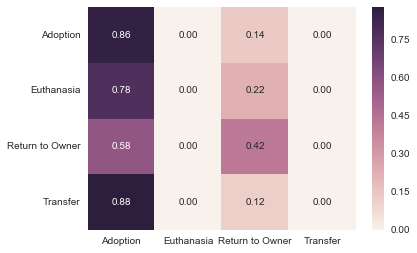

In [25]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y, y_predicted):
    ''' take true and predicted scores and plot confusion matrix '''
    # Get the confusion matrix
    cm = confusion_matrix(y, y_predicted)

    # Normalize the confusion matrix by dividing each row by its sum
    ncm = cm / cm.sum(axis=1)[:, np.newaxis]

    # Put into DataFrame and get all labels from the encoder
    class_labels = encoder.classes_
    ncm = pd.DataFrame(ncm, index=class_labels, columns=class_labels)

    # Rows are true classes, columns are assigned classes
    sns.heatmap(data=ncm, fmt='.2f', annot=True)
    
plot_confusion_matrix(y, y_predicted)

### Ruh-roh...
* That 40% accuracy rate is a little misleading
* The classifier is performing this well by assigning the same classes everywhere
* We need to fix this

In [26]:
# The classification report shows us performance for
# the most common metrics, by class
from sklearn.metrics import classification_report

print(classification_report(y, y_predicted))

             precision    recall  f1-score   support

          0       0.41      0.86      0.56     15571
          1       0.00      0.00      0.00      3890
          2       0.39      0.42      0.40      6803
          3       0.00      0.00      0.00     13776

avg / total       0.23      0.41      0.29     40040



/Users/tal/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Iterating
* Let's iteratively try to improve the model performance by:
    * Adding features (we have plenty!)
    * Making sure the estimator respects class weights
    * Trying different estimators

In [33]:
# For models with categoricals, we can call on
# patsy to dummy-code our variables, like we did
# when working with statsmodels
from patsy import dmatrices

# Some estimators we can try (there are many more!)
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.cross_validation import cross_val_score

# overfitting central!
est = DecisionTreeClassifier()

# Set up the features--let's go big this time
X = data[['age']]

# We already set up y, so we're just passing in 1 here
# as a dummy. Note that we store it in a variable named
# _ on the return, which is a convention to indicate
# somethign we want to throw away. It's only the X's
# we care about here.
# _, X = dmatrices('1 ~ age', data=X)

# Add in the features we extracted/selected
# X = np.c_[X.data, selected_features]
X = np.c_[X.values, lotsa_features]

est.fit(X, y)
y_pred = est.predict(X)

# Be skeptical!
accuracy_score(y, y_pred)

0.84637862137862141

## Cross-validation
* Hopefully performance now looks reasonable
* But there's still a potential problem: overfitting
* We're training and evaluating on the same dataset--this is a big no-no!
* scikit-learn provides easy ways to evaluate models out-of-sample
    * This is known as cross-validation

In [28]:
# Import KFold cross-validation
from sklearn.cross_validation import KFold
from sklearn.metrics import f1_score

est = DecisionTreeClassifier()

# Placeholder for scores from each fold
scores = []

# Create k folds (in our case 5). Loop over the folds,
# and for each one, split the dataset into training and test.
# In each fold, we train the data on the training values,
# and then evaluate its performance on the test. Finally,
# we can take the average of the out-of-sample scores as
# our estimate of model performance.
folds = KFold(n=len(X), n_folds=5, shuffle=True)
for train, test in folds:
#     print(train, test)
    est.fit(X[train], y[train])
    pred_y = est.predict(X[test])
    fold_score = f1_score(y[test], pred_y, average='weighted')
    scores.append(fold_score)
    
# Overfitting be gone!
print(np.array(scores))

[ 0.58702701  0.58969159  0.58941551  0.59317643  0.58348452]


# Model selection
* We've experimented a lot with estimators, decomposition, evaluation, etc.
* This is only the tip of the iceberg...
* scikit-learn has hundreds of estimators!
* Two problems:
    1. How are we supposed to choose?
    2. How do we do this in a principled way?
* Requirement for both is an automated, principled way to execute a pipeline

# Fully automated pipelines
* We've done feature extraction, reduction, and selection; estimation; evaluation...
* But we need to automate this
    * Both for efficiency, and to prevent overfitting
* sklearn.pipeline provides functionality for creating [fully automated Pipelines](http://scikit-learn.org/stable/modules/pipeline.html)
* We'll build a toy example with 2 steps, but we could chain our entire workflow

In [29]:
# Import the Pipeline class
from sklearn.pipeline import Pipeline

# Initialize a list to store all the steps in our pipeline
steps = []

# Add feature selection
selector = SelectKBest(k=100)
steps.append(('select', selector))

# Add estimation
estimator = LogisticRegression()
steps.append(('estimate', estimator))

# Initialize the pipeline
pipeline = Pipeline(steps)

In [30]:
# Fit the pipeline
_y_pred = pipeline.fit(X, y)

## The fit-predict interface
* scikit-learn is built around the estimator interface
* "An estimator is an object that fits a model based on some training data and is capable of inferring some properties on new data"
* Every estimator must implement fit() and predict() methods
* Makes it easy to extend scikit-learn with our own estimators

### Building our own estimator

In [32]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class MercurialClassifier(BaseEstimator, ClassifierMixin):
    """Picks a random class and assigns that label to all cases."""

    def fit(self, X, y):
        ''' Selects a random class from the available options '''
        classes = np.unique(y)
        self.selected_ = np.random.choice(classes)
        return self

    def predict(self, X):
        ''' Applies the selected class to everything '''
        return np.repeat(self.selected_, len(X))

# The End
* I hope you enjoyed the course and/or learned something useful!
* The links throughout the notebooks contain plenty of further resources
* Consider registering for [SciPy 2016](scipy2016.scipy.org) (here in July)--they have great tutorials
* Feedback/suggestions for improvement is welcome
* Please fill out a course evaluation before you leave